In [1]:
import torch
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from models.fair import BinaryFair
from models.flow import Flow
from models.classifier import BinaryClassifier
from utils.StatisticalDistance import EmpiricalStatisticalDistance
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.metrics import accuracy_score
from tqdm.auto import trange

%load_ext autoreload
%autoreload 2

In [2]:
data_file = torch.load("data/Crime/data.pt")

/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


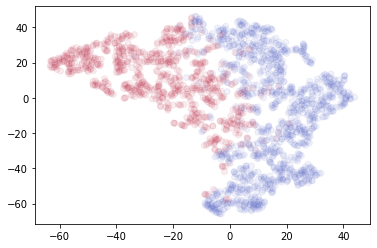

In [3]:
X_embedded = TSNE(n_components=2).fit_transform(data_file['data'])
plt.scatter(*X_embedded.T, c=data_file['context'], alpha=0.07, cmap='coolwarm')

In [4]:
# Parameters
params = {'batch_size': 128,
          'shuffle': True}

# Split data by label
data_0 = data_file['data'][data_file['context'].flatten() == 0]
labels_0 = data_file['labels'][data_file['context'].flatten() == 0]
context_0 = data_file['context'][data_file['context'].flatten() == 0]

data_1 = data_file['data'][data_file['context'].flatten() == 1]
labels_1 = data_file['labels'][data_file['context'].flatten() == 1]
context_1 = data_file['context'][data_file['context'].flatten() == 1]

# Generators
label_0_set = TensorDataset(data_0, labels_0, context_0)
label_0_generator = torch.utils.data.DataLoader(label_0_set, **params)

label_1_set = TensorDataset(data_1, labels_1, context_1)
label_1_generator = torch.utils.data.DataLoader(label_1_set, **params)


In [5]:
# Parameters
params = {'batch_size': 128,
          'shuffle': True}

# Generators
data_set = TensorDataset(data_file['data'], data_file['context'])
data_generator = torch.utils.data.DataLoader(data_set, **params)

In [6]:
probability_flow = Flow(data_dim=data_file['data'].shape[-1], 
                  context_dim=data_file['context'].shape[-1],
                  n_layers = 3,
                  transform_type = 'MaskedAffineAutoregressiveTransform', 
        )
optimizer = torch.optim.AdamW(probability_flow.parameters(), lr=1e-3, weight_decay=1e-4)

In [7]:
n_steps = 2000
probability_loss = []
probability_flow.train()
for n_step in trange(n_steps):
    data, context = next(iter(data_generator))
    
    optimizer.zero_grad()

    loss = -probability_flow.log_prob(inputs=data, context=context).mean()
    probability_loss.append(loss.item())
    loss.backward()
    optimizer.step()
probability_flow.eval();

100%|██████████| 2000/2000 [00:15<00:00, 130.98it/s]


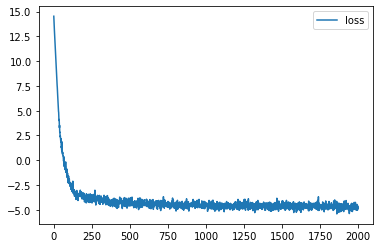

In [8]:
plt.plot(probability_loss, label="loss")
xlims = plt.xlim()
ylims = plt.ylim()
plt.legend()
plt.show()

In [9]:
probability_flow._log_prob(data_file['data'][0:1], None)

tensor([-11.6935], grad_fn=<AddBackward0>)

/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


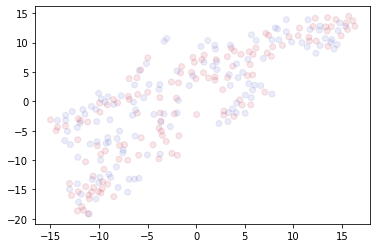

In [10]:
data, context = next(iter(data_generator))
data_embedded = TSNE(n_components=2).fit_transform(data)
samples = probability_flow._sample(num_samples=1, context=context)

catData = torch.cat((data, samples.squeeze(dim=1)))
catData_embedded = TSNE(n_components=2).fit_transform(catData.detach().numpy())
catLabel = torch.cat((torch.zeros(data.shape[0]), torch.ones(samples.shape[0])))

plt.scatter(*catData_embedded.T, c=catLabel, alpha=0.1, cmap='coolwarm')

In [11]:
gamma = 0.90
Fair = BinaryFair(data_dim=data_file['data'].shape[-1], 
                  context_dim=data_file['context'].shape[-1], 
                  flow_n_layers = 4,
                  flow_transform_type = 'MaskedAffineAutoregressiveTransform', 
                  classifier_hidden_dim = 32,
                  classifier_n_layers = 4,
                  classifier_activation = 'ReLU',
                  gamma=gamma
                 )
optimizer = torch.optim.AdamW(Fair.parameters(), lr=1e-3, weight_decay=1e-4)
total_losses = []
KL_losses = []
clf_losses = []

In [12]:
n_steps = 2000
Fair.train()
for n_step in trange(n_steps):
    data_0, labels_0, context_0 = next(iter(label_0_generator))
    data_1, labels_1, context_1 = next(iter(label_1_generator))
    
    optimizer.zero_grad()

    L_KL, L_clf, loss = Fair.loss(data_0, data_1, labels_0=labels_0, labels_1=labels_1, context_0=context_0, context_1=context_1, return_all_losses=True, probability_flow=probability_flow)

    total_losses.append(loss.item())
    KL_losses.append(L_KL.item())
    clf_losses.append(L_clf.item())

    loss.backward()
    optimizer.step()
Fair.eval();

100%|██████████| 2000/2000 [03:53<00:00,  8.56it/s]


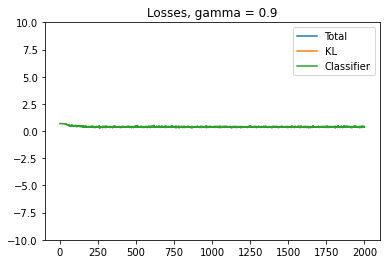

In [13]:
plt.plot(total_losses, label="Total")
xlims = plt.xlim()
ylims = plt.ylim()
plt.plot(KL_losses, label="KL")
plt.plot(clf_losses, label="Classifier")
plt.legend()
plt.xlim(*xlims)
plt.ylim(-10,10)
plt.title("Losses, gamma = " + str(gamma))
# plt.savefig("Figures/losses_gamma_" + str(gamma) + ".png")
plt.show()

In [14]:
#When gamma = 0, Fair.flow0._transform returns nans on the data
# Fair.flow0._transform(data_0, context=None)

Text(0.5, 1.0, 'Embedding, gamma = 0.9')

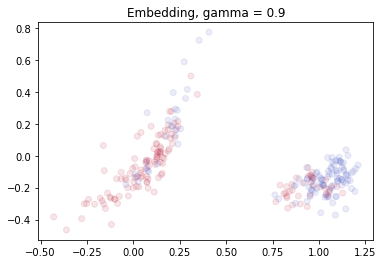

In [15]:
data_0, labels_0, _ = next(iter(label_0_generator))
data_1, labels_1, _ = next(iter(label_1_generator))

embedding_0, embedding_1 = Fair._embed(data_0, data_1, context_0=None, context_1=None)

plt.scatter(*embedding_0.T[0:2].detach(), alpha=0.1, c=labels_0, cmap='coolwarm')
plt.scatter(*embedding_1.T[0:2].detach(), alpha=0.1, c=labels_1, cmap='coolwarm')

plt.title("Embedding, gamma = " + str(gamma))
# plt.savefig("Figures/embedding_gamma_" + str(gamma) + ".png")

In [16]:
with torch.no_grad():
    cont_pred = Fair(data_file['data'], data_file['context'])
    bin_pred = (cont_pred > 0.5).int()
    acc = accuracy_score(bin_pred, data_file['labels'])
acc

0.7848545636910732

Accuracies:
    gamma = 0. : 0.84  # paper achieves 85.2 (not too far off)
    gamma = 1. : 0.5

/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0.5, 1.0, 'TSNE Embedding, gamma = 0.9')

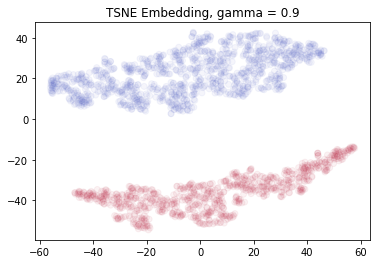

In [17]:
#Interpreting the representations
with torch.no_grad():
    idx = (data_file["context"] == 0).flatten()
    data_0 = data_file["data"][idx]
    data_1 = data_file["data"][~idx]

    # x0 = probability_flow.sample(num_samples=1, context=data_file["context"][idx]).squeeze()
    # x1 = probability_flow.sample(num_samples=1, context=data_file["context"][~idx]).squeeze()

    embedding_0, embedding_1 = Fair._fair_embed(
        x0=data_0, x1=data_1
    )
    embedding = torch.cat([data_0, embedding_0])
    X_embedded = TSNE(n_components=2).fit_transform(embedding)
embed_labels = torch.cat([torch.zeros(data_0.shape[0]), torch.ones(embedding_0.shape[0])])
plt.scatter(*X_embedded.T, c=embed_labels, alpha=0.05, cmap="coolwarm")
plt.title("TSNE Embedding, gamma = " + str(gamma))
# plt.savefig("Figures/tsne_clustering_gamma_" + str(gamma) + ".png")

For gamma = 1, these two should be on top of one another, but they're not!

/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/Nolan/Dropbox/FNF4HEP/FNF4HEP/.venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0.5, 1.0, 'TSNE Data vs. Embedding, gamma = 0.9')

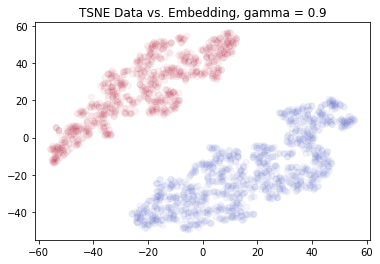

In [18]:
with torch.no_grad():
    idx = (data_file["context"] == 0).flatten()
    embedding_0, embedding_1 = Fair._embed(
        data_file["data"][idx], data_file["data"][~idx]
    )
    embedding = torch.cat([embedding_0, embedding_1])
    X_embedded = TSNE(n_components=2).fit_transform(embedding)
    embed_labels = torch.cat([torch.zeros(embedding_0.shape[0]), torch.ones(embedding_1.shape[0])])
plt.scatter(*X_embedded.T, c=embed_labels, alpha=0.05, cmap="coolwarm")
plt.title("TSNE Data vs. Embedding, gamma = " + str(gamma))
# plt.savefig("Figures/tsne_data_embedding_gamma_" + str(gamma) + ".png")


In [19]:
with torch.no_grad():
    idx = (data_file["context"] == 0).flatten()
    
    embedding_0, embedding_1 = Fair._embed(
        data_file["data"][idx], data_file["data"][~idx]
    )

EmpiricalStatisticalDistance(
    embedding_0, embedding_1, hidden_dim=64, n_layers=5, n_epochs=100
)


100%|██████████| 100/100 [00:07<00:00, 12.67it/s]

Training set accuracy: 1.000
Test set accuracy: 1.000


tensor(1.0000, grad_fn=<AbsBackward0>)

In [20]:
#Optimal Adversary
#TODO: need to add the context to the data
# idx = (data_file["context"] == 0).flatten()
# data_0 = data_file["data"][idx]
# data_1 = data_file["data"][~idx]
# context_0 = data_file["context"][idx]
# context_1 = data_file["context"][~idx]
data_0, labels_0, context_0 = next(iter(label_0_generator))
data_1, labels_1, context_1 = next(iter(label_1_generator))

mu_star_0_avg, mu_star_1_avg, stat_dist, logP_Z0_z0, logP_Z1_z1, logP_Z0_z1, logP_Z1_z0 = Fair.optimal_adversary(data_0, data_1, context_0=context_0, context_1=context_1, probability_flow=probability_flow)

In [21]:
print("mu_star_0_avg:", mu_star_0_avg, "mu_star_1_ave:", mu_star_1_avg, "stat_dist:", stat_dist)

mu_star_0_avg: tensor(0.) mu_star_1_ave: tensor(1.) stat_dist: tensor(-1.)


(array([ 2.,  3.,  2.,  1., 11., 19., 21., 22., 40.,  7.]),
 array([-44.424774, -40.914936, -37.405098, -33.895264, -30.385426,
        -26.875587, -23.36575 , -19.855913, -16.346075, -12.836238,
         -9.326401], dtype=float32),
 <BarContainer object of 10 artists>)

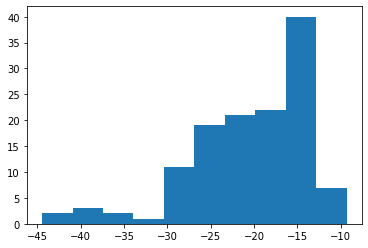

In [23]:

plt.hist((logP_Z1_z0-logP_Z0_z0).detach().numpy())

In [ ]:
print(f'mu0 = {mu_star_0_avg}, mu1 = {mu_star_1_avg}, stat_dist = {stat_dist}')

mu0 = 0.984375, mu1 = 0.003562945406883955, stat_dist = 0.9808120727539062
